# Benchmark PSO / PSO Hybride / Algorithme Génétique sur CEC2017 

<h4 >Préparé par:  Yessine Abdelmaksoud & Med Ali Abid</h4>

Ce notebook compare trois algorithmes d'optimisation globale :

- **PSO Classique**
- **PSO Hybride (PSO + mutation gaussienne)**
- **Algorithme Génétique (GA)**

Nous utilisons plusieurs fonctions du benchmark **CEC2017** (f2, f4, f12, f25) pour analyser la capacité de chaque algorithme à converger dans des espaces complexes.


L’axe **horizontal** dans les graphiques sera :  
> **Nombre total d’évaluations de la fonction objectif**

L’axe **vertical** sera :  
> **Meilleure valeur trouvée (moyenne par blocs, échelle log)**  


## Imports & paramètres globaux

Dans cette cellule :
- On charge le module `cec2017`
- On importe les fonctions de test : `f2`, `f4`, `f12`, `f25`
- On fixe les paramètres globaux :
  - Dimension = 30
  - Population = 30
  - Nombre d’itérations = 1000
  - Bornes : [-100, 100]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import cec2017

# Charger le sous-module contenant les fonctions CEC2017
cec_functions = importlib.import_module("cec2017.functions")

# Sélectionner les fonctions de test
f2 = cec_functions.f2
f4 = cec_functions.f4
f12 = cec_functions.f12
f25 = cec_functions.f25

functions = {"f2": f2, "f4": f4, "f12": f12, "f25": f25}

print("✅ Fonctions CEC2017 chargées :", list(functions.keys()))

# Paramètres globaux du benchmark
DIM = 30          # dimension
POP = 30          # taille de population
TMAX = 1000       # nombre d'itérations
STEP = 30         # taille des blocs pour le lissage
LB, UB = -100, 100  # bornes générales des fonctions CEC


✅ Fonctions CEC2017 chargées : ['f2', 'f4', 'f12', 'f25']


## Fonction d'évaluation par batch

Les fonctions CEC prennent en entrée un tableau `(N, D)` et renvoient un tableau de taille `N`.

Cette cellule définit une fonction utilitaire `evaluate()` qui garantit un retour propre sous forme de tableau 1D.


In [3]:
def evaluate(func, positions):
    """
    Évalue la fonction sur un ensemble de positions (batch) et renvoie un tableau 1D.
    func : fonction qui prend un array (N, D) et renvoie un array de taille N.
    """
    values = np.asarray(func(positions), dtype=float)
    return values.reshape(values.shape[0]) if values.ndim > 1 else values


## Implémentation du PSO Standard & PSO Hybride

### PSO Standard :
- Inertie décroissante
- Mise à jour basée sur `pbest` et `gbest`
- Historique : meilleure valeur par itération

### PSO Hybride :
- PSO classique **+ mutation gaussienne aléatoire** sur certaines coordonnées
- Favorise l’exploration

In [4]:
def pso_standard(func, rng, D=30, N=30, LB=-100, UB=100, c1=2.0, c2=2.0, Tmax=1000):
    """Algorithme PSO classique — suit la meilleure valeur globale à chaque itération."""
    x = rng.uniform(LB, UB, size=(N, D))
    v = np.zeros((N, D))
    pbest = x.copy()
    pbest_values = evaluate(func, x)

    g_best = pbest[np.argmin(pbest_values)].copy()
    history = np.zeros(Tmax)

    for t in range(Tmax):
        w = 0.9 - 0.5 * t / Tmax   # inertie décroissante
        r1, r2 = rng.random((N, D)), rng.random((N, D))

        v = w * v + c1 * r1 * (pbest - x) + c2 * r2 * (g_best - x)
        x = np.clip(x + v, LB, UB)
        fitness = evaluate(func, x)

        improved = fitness < pbest_values
        if np.any(improved):
            pbest[improved] = x[improved]
            pbest_values[improved] = fitness[improved]

        g_best = pbest[np.argmin(pbest_values)]
        history[t] = pbest_values.min()

    return history


def pso_hybrid(func, rng, D=30, N=30, LB=-100, UB=100, c1=2.0, c2=2.0, Tmax=1000,
               p_mut=0.05, sigma=25.0):
    """PSO avec mutation gaussienne — améliore l'exploration de l'espace de recherche."""
    x = rng.uniform(LB, UB, size=(N, D))
    v = np.zeros((N, D))
    pbest = x.copy()
    pbest_values = evaluate(func, x)

    g_best = pbest[np.argmin(pbest_values)].copy()
    history = np.zeros(Tmax)

    for t in range(Tmax):
        w = 0.9 - 0.5 * t / Tmax
        r1, r2 = rng.random((N, D)), rng.random((N, D))

        v = w * v + c1 * r1 * (pbest - x) + c2 * r2 * (g_best - x)
        x += v

        # Mutation gaussienne sur certaines coordonnées
        mutation_mask = rng.random((N, D)) < p_mut
        if np.any(mutation_mask):
            x += mutation_mask * rng.normal(0.0, sigma, size=(N, D))

        x = np.clip(x, LB, UB)
        fitness = evaluate(func, x)

        improved = fitness < pbest_values
        if np.any(improved):
            pbest[improved] = x[improved]
            pbest_values[improved] = fitness[improved]

        g_best = pbest[np.argmin(pbest_values)]
        history[t] = pbest_values.min()

    return history


## Implémentation de l'Algorithme Génétique (GA)

Caractéristiques :
- Croisement à un point (split = D/2)
- Mutation d’un gène par individu
- Élitisme : on conserve toujours les N meilleurs


In [5]:
def genetic_algorithm(func, rng, D=30, N=30, LB=-100, UB=100, Tmax=1000, mutation_scale=0.005):
    """
    Algorithme génétique (GA) simple :
    - Croisement à un point (split = D//2)
    - Mutation d'un gène aléatoire par individu
    - Élitisme (on garde toujours les N meilleurs individus)
    """
    split = D // 2
    mutation_amplitude = mutation_scale * (UB - LB)

    parents = rng.uniform(LB, UB, size=(N, D))
    fitness = evaluate(func, parents)
    history = np.zeros(Tmax)

    for t in range(Tmax):
        # Sélection aléatoire de paires de parents
        j = rng.integers(0, N, size=N)
        k = rng.integers(0, N, size=N)

        # Croisement à un point
        enfants = np.hstack((parents[j, :split], parents[k, split:]))

        # Mutation mono-gène
        mutation_idx = rng.integers(0, D, size=N)
        enfants[np.arange(N), mutation_idx] += rng.uniform(
            -mutation_amplitude, mutation_amplitude, size=N
        )
        np.clip(enfants, LB, UB, out=enfants)

        # Évaluation et élitisme
        enfants_fit = evaluate(func, enfants)
        combined = np.vstack((parents, enfants))
        combined_fit = np.concatenate((fitness, enfants_fit))

        best_idx = np.argsort(combined_fit)[:N]
        parents, fitness = combined[best_idx], combined_fit[best_idx]

        history[t] = fitness[0]  # meilleure valeur de la génération

    return history


##  Moyenne par blocs & conversion itérations → évaluations

Pour obtenir un axe horizontal qui reflète réellement l'effort de calcul,  
on convertit les **itérations** en **nombre total d’évaluations** :

$$
\text{Évaluations} = \text{Itérations} \times \text{POP}
$$

Ainsi, chaque itération correspond à l’évaluation de `POP` candidats.

Cette cellule définit une fonction qui :
- découpe l’historique en **blocs de taille fixe**,
- calcule la **moyenne** dans chaque bloc,
- retourne l’axe horizontal exprimé en **nombre d’évaluations**,  
  et non plus en simple numéro d’itération.



In [6]:
def moyenne_blocs(values, pas=30, evals_par_iter=POP):
    """
    Calcule la moyenne par blocs de 'pas' itérations.
    Retourne :
      - x_axis : nombre total d'évaluations pour chaque bloc
      - y_axis : moyenne des valeurs de 'values' dans ce bloc
    """
    n_blocs = len(values) // pas
    moyennes = [
        np.mean(values[i * pas : (i + 1) * pas])
        for i in range(n_blocs)
    ]
    # Bloc 1 => pas itérations => pas * evals_par_iter évaluations, etc.
    x_axis = np.arange(1, n_blocs + 1) * pas * evals_par_iter
    return np.array(x_axis), np.array(moyennes)


## Exécution des 3 algorithmes sur chaque fonction CEC2017

Chaque fonction est évaluée par :
- PSO classique  
- PSO hybride  
- Algorithme génétique  

Chaque algo retourne un historique de la meilleure valeur trouvée par itération.


In [7]:
def executer_algos():
    """
    Exécute PSO classique, PSO hybride et GA sur chaque fonction CEC2017.
    Retour :
        dict[ nom_fonction ] = {
            "PSO Classique": history_array,
            "PSO Hybride": history_array,
            "Algorithme Génétique": history_array
        }
    """
    resultats = {}
    for nom_f, f in functions.items():
        print(f"\n🔹 Exécution sur {nom_f}...")
        
        # Adapter la fonction CEC : X arrive en (N, D)
        f_eval = lambda X: f(X.reshape(X.shape[0], -1))
        
        # Graine fixe pour la reproductibilité sur cette fonction
        rng = np.random.default_rng(42)
        
        resultats[nom_f] = {
            "PSO Classique": pso_standard(f_eval, rng=rng, D=DIM, N=POP, LB=LB, UB=UB, Tmax=TMAX),
            "PSO Hybride": pso_hybrid(f_eval, rng=rng, D=DIM, N=POP, LB=LB, UB=UB, Tmax=TMAX),
            "Algorithme Génétique": genetic_algorithm(f_eval, rng=rng, D=DIM, N=POP, LB=LB, UB=UB, Tmax=TMAX)
        }
    return resultats


resultats = executer_algos()
print("\n✅ Exécution terminée.")



🔹 Exécution sur f2...

🔹 Exécution sur f4...

🔹 Exécution sur f12...

🔹 Exécution sur f25...

✅ Exécution terminée.


# Visualisation de la convergence

Cette cellule trace pour chaque fonction CEC :

- L’avancement en **nombre total d’évaluations**
- La **moyenne par blocs** de la meilleure valeur trouvée
- Une **échelle log** pour mieux comparer les algorithmes


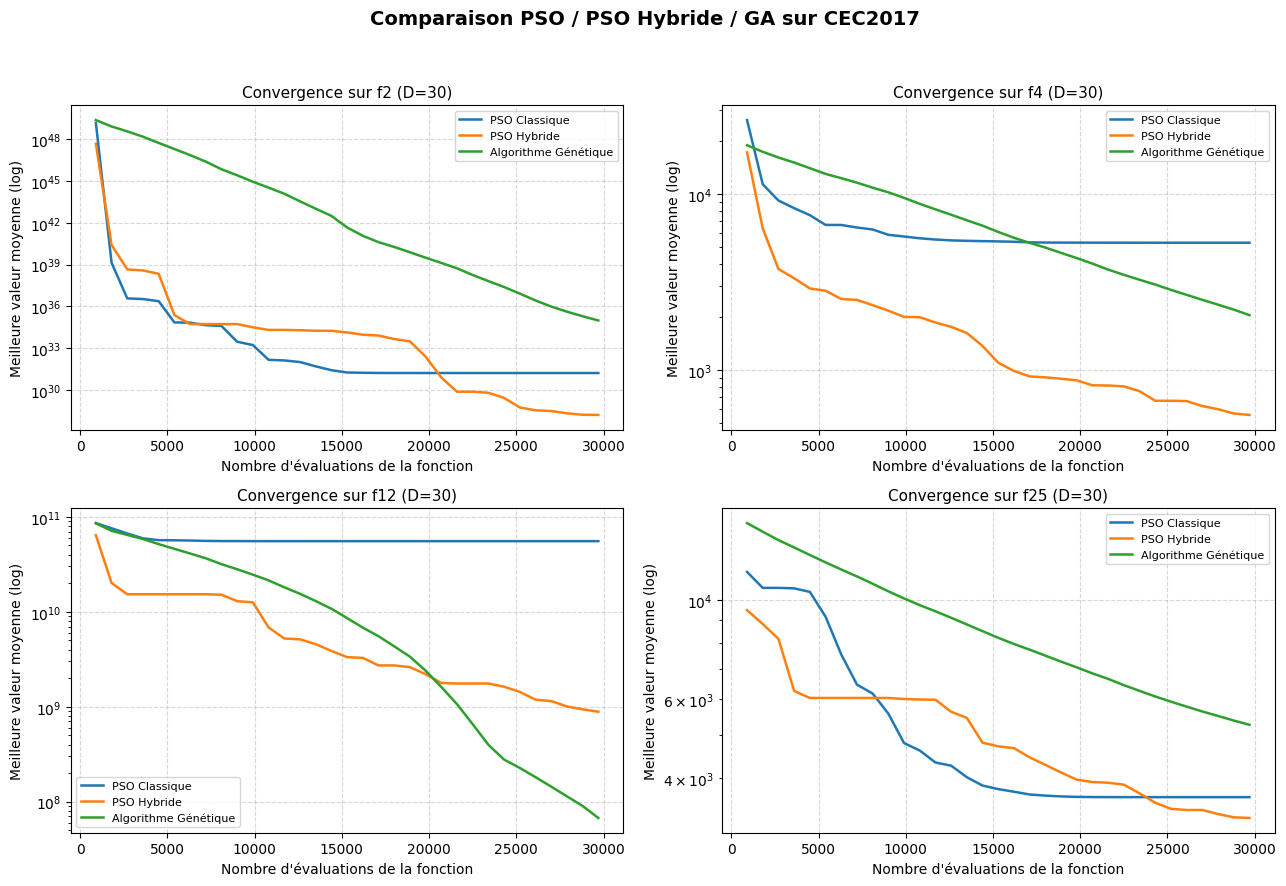

In [8]:
plt.figure(figsize=(13, 9))

for i, (nom_f, courbes) in enumerate(resultats.items(), start=1):
    plt.subplot(2, 2, i)
    for nom_algo, hist in courbes.items():
        x, y = moyenne_blocs(hist, pas=STEP, evals_par_iter=POP)
        plt.plot(x, y, label=nom_algo, linewidth=1.8)
    
    plt.title(f"Convergence sur {nom_f} (D={DIM})", fontsize=11)
    plt.xlabel("Nombre d'évaluations de la fonction")
    plt.ylabel("Meilleure valeur moyenne (log)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.yscale("log")
    plt.legend(fontsize=8)

plt.suptitle("Comparaison PSO / PSO Hybride / GA sur CEC2017", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
